Explicit Finite Differences Method for Option Valuation

Includes Call and Puts / American and European

In [13]:
import math
import numpy as np
import pandas as pd
import xlwings as xw
import scipy as sp
from scipy import stats
import matplotlib as plt

In [14]:
T = 1  #Time to Expiry in Years
E = 100  #Strike
r = .05  #Risk Free Rate
SIGMA = .20  #Volatility
Type = False   #Type of Option True=Call False=Put
Ex = False #Early Exercise True=Yes  False=No 
NAS = 40  #Number of Asset Steps - Higher is more accurate, but more time consuming

ds = 2 * E / NAS  #Asset Value Step Size
dt = (0.9/NAS/NAS/SIGMA/SIGMA)  #Time Step Size
NTS = int(T / dt) + 1  #Number of Time Steps
dt = T / NTS #Time Step Size
print("Asset Step Size %.2f Time Step Size %.2f Number of Time Steps %.2f Number of Asset Steps %.2f" %(ds, dt, NTS, NAS))

Asset Step Size 5.00 Time Step Size 0.01 Number of Time Steps 72.00 Number of Asset Steps 40.00


In [15]:
#Setup Empty numpy Arrays
value_matrix = np.zeros((int(NAS+1), int(NTS)))
asset_price = np.arange(NAS*ds,-1,-ds)

In [16]:
#Evaluate Terminal Value for Calls or Puts
if Type == True:
    value_matrix[:,-1]= np.maximum(asset_price - E,0)
else:
    value_matrix[:,-1]= np.maximum(E - asset_price,0)

In [17]:
#Set Lower Boundry in Grid
for x in range(1,NTS):
    value_matrix[-1,-x-1] = value_matrix[-1,-x]* math.exp(-r*dt)

In [18]:
#Set Mid and Ceiling Values in Grid
for x in range(1,int(NTS)):

    for y in range(1,int(NAS)):
        #Evaluate Option Greeks
        Delta = (value_matrix[y-1,-x] - value_matrix[y+1,-x]) / 2 / ds
        Gamma = (value_matrix[y-1,-x] - (2 * value_matrix[y,-x]) + value_matrix[y+1,-x]) / ds / ds
        Theta = (-.5 * SIGMA**2 * asset_price[y]**2 * Gamma) - (r * asset_price[y] * Delta) + (r * value_matrix[y,-x])
        
        #Set Mid Values
        value_matrix[y,-x-1] = value_matrix[y,-x] - Theta * dt
        if Ex == True:
            value_matrix[y,-x-1] = np.maximum(value_matrix[y,-x-1], value_matrix[y,-1])
          

        #Set Ceiling Value
        value_matrix[0,-x-1] = 2 * value_matrix[1,-x-1] - value_matrix[2,-x-1] 

#Export Value Grid to Excel via xlWings
xw.view(value_matrix)

In [19]:
#Option Valuation Profile in pandas - Index is Strike Price, column 0 is the option price
value_df = pd.DataFrame(value_matrix)
value_df = value_df.set_index(asset_price)

#Export Value Grid to Excel via xlWings
xw.view(value_df)

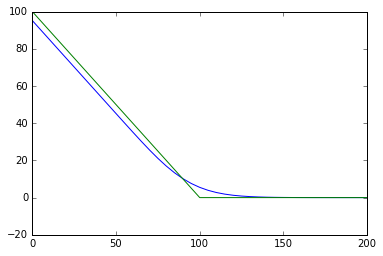

In [25]:
%matplotlib inline
#Payoff Plot
plot_df = value_df.sort_index(ascending=True)
plot_df[0].plot()
plot_df[NTS-1].plot()

Calculation of Option Value using BSM for Comparison - Works for European Options Only

In [21]:
'''BSM VANILLA EUROPEAN OPTION VALUE CALCULATION'''
def bsm_option_value(S0, E, T, R, SIGMA):   
    S0 = float(S0)
    d1 = (math.log(S0/E)+(R+(0.5*SIGMA**2))*T)/(SIGMA*math.sqrt(T))
    d2 = d1-(SIGMA*math.sqrt(T))
    call_value = S0*stats.norm.cdf(d1,0,1) - E*math.exp(-R*T)*stats.norm.cdf(d2,0,1)
    delta_call = stats.norm.cdf(d1,0,1)
    gamma_call = stats.norm.pdf(d1,0,1)/(S0*SIGMA*math.sqrt(T))
    theta_call = -(R*E*math.exp(-R*T)*stats.norm.cdf(d2,0,1))-(SIGMA*S0*stats.norm.pdf(d1,0,1)/(2*math.sqrt(T)))
    rho_call = T*E*math.exp(-R*T)*stats.norm.cdf(d2,0,1)
    vega_call = math.sqrt(T)*S0*stats.norm.pdf(d1,0,1)
    
    put_value =  E*math.exp(-R*T)*stats.norm.cdf(-d2,0,1) - (S0*stats.norm.cdf(-d1,0,1))
    delta_put = -stats.norm.cdf(-d1,0,1)
    gamma_put = stats.norm.pdf(d1,0,1)/(S0*SIGMA*math.sqrt(T))
    theta_put = (R*E*math.exp(-R*T)*stats.norm.cdf(-d2,0,1))-(SIGMA*S0*stats.norm.pdf(d1,0,1)/(2*math.sqrt(T)))
    rho_put = -T*E*math.exp(-R*T)*stats.norm.cdf(-d2,0,1)
    vega_put = math.sqrt(T)*S0*stats.norm.pdf(d1,0,1)
    
    return call_value, delta_call, gamma_call, theta_call, rho_call, vega_call, put_value, delta_put, gamma_put, theta_put, rho_put, vega_put

In [22]:
#Run BSM Calculation for values and greeks
S0 = 100  #Current Value
R=r
#BSM function call and output assignment
call_value, delta_call, gamma_call, theta_call, rho_call, vega_call, put_value, delta_put, gamma_put, theta_put, rho_put, vega_put = bsm_option_value(S0, E, T, R, SIGMA)

if Type == False:
    BSM_val = put_value
if Type == True:
    BSM_val = call_value
print(BSM_val)

5.57352602226


In [23]:
#Finite Differences Method Value at S0
fd_value = value_df.ix[S0,1]
print(fd_value)

5.47684205529


In [24]:
#Difference
diff = put_value - fd_value
print("Nominal Difference is %.4f" %diff)

pct_diff = abs(diff / put_value)
print("Percent Difference is {percent:.4%}".format(percent=pct_diff))

#If you want higher accuracy you can increase the number of asset steps

Nominal Difference is 0.0967
Percent Difference is 1.7347%
